# Markov Chain Monte Carlo

### A Mindmap for the concepts of Monte Carlo methods

![](https://cloud.githubusercontent.com/assets/1029280/8974702/ce41505a-36af-11e5-8e1d-808f8d354d70.png)

### Import libraries

In [1]:
%matplotlib inline
import seaborn
import scipy

In [2]:
seaborn.set_context("talk")

### Prepare for animations

In [3]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

In [4]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [5]:
from matplotlib import animation

### Simple Monte Carlo example

We start from a simple task, compute the expectation

$$ {\rm I\kern-.3em E}[\phi(x)] , $$

In which

$$ \phi(x) = 0.03 x + 0.2 ,$$

$$ x \sim \frac{2}{3}(\mathcal{N}(2, 1) + \frac{1}{2} \mathcal{N}(-1, 1)) . $$

The true value should be 0.23 (as the expected output of target distribution is the 1)


In [6]:
def target_distribution(x):
    return (scipy.stats.norm.pdf(x, loc=2) + scipy.stats.norm.pdf(x, loc=-1) * 0.5) / 1.5

def phi(x):
    return 0.03 * x + 0.2

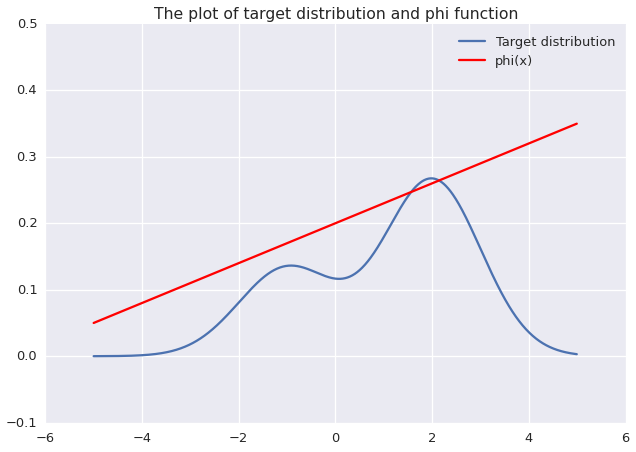

In [57]:
x_axis = np.arange(-5, 5, 0.01)
target_plot = plt.plot(x_axis, map(target_distribution, x_axis), label="Target distribution")
plt.plot(x_axis, map(phi, x_axis), label="phi(x)", c="r")
plt.legend()
plt.ylim(-0.1, 0.5)
plt.xlim(-6, 6)
plt.title("The plot of target distribution and phi function")
plt.show()

Note, when we are sampling, we do not know the shape of the whole distribution, sampling is just finding your glass when you can not see anything.

Let's try to sample from a different by similar distribution:

$$ \mathcal{N}(2, 1.5) .$$

In [191]:
# Draw the stational things in the animation

def sampling_distribution(x):
    return scipy.stats.norm.pdf(x, loc=2, scale=1.5)

fig = plt.figure()
ax1 = plt.subplot(211, xlim=(-6, 6), ylim=(-0.1, 0.5))
ax1.plot(x_axis, map(target_distribution, x_axis), label="Target distribution")
ax1.plot(x_axis, map(sampling_distribution, x_axis), label="Sampling distribution")
ax1.set_title("Samples drawed from a wrong normal distribution")
ax1_scat = ax1.scatter([], [], alpha=0.5, label="Samples")
ax1_scat_current = ax1.scatter([], [], alpha=0.5, c="k", s=100, marker="o")
ax1.legend()

ax2 = plt.subplot(212, xlim=(-1, 100), ylim=(0.1, 0.3))
ax2.set_title("The approximation of expectation")
ax2_plot, = ax2.plot([], [], label="Expectation of phi")
ax2.plot([-10, 300], [0.23, 0.23], 'k-', alpha=0.5, label="True value")
ax2.legend()

samples = []
expect_history = []

def animate(i):
    # Sample from normal distribution
    samples.append(np.random.normal(2, 0.8))
    ax1_scat.set_offsets( np.array(zip(samples, np.repeat(-0.05, len(samples)))) )
    ax1_scat_current.set_offsets([(samples[-1], -0.05)])
    # Compute expectation
    expect = sum([phi(x) for x in samples]) / len(samples)
    expect_history.append((i, expect))
    ax2_plot.set_data(map(np.array, zip(*expect_history)))
    return

anim = animation.FuncAnimation(fig, animate, frames=100, interval=20, blit=True)
display_animation(anim)

Now, we can see that we got a totally wrong approximation result, so sampling from a similar distribution does not work.

### Rejection sampling

Rejection sampling works in the following way:
- We make a sampling distribution $k \tilde Q(x)$, which is not normalized
 - Our target distribution $\tilde P(x)$ should be underneath  $k \tilde Q(x)$
- Draw a sample $x \sim Q(x)$
- Draw a random height $u \sim \mbox{uniform}[0, k \tilde Q(x)]$
- We accept the sample if $u \lt \tilde P(x)$

In [197]:
np.random.seed(3)
# Draw the stational things in the animation
def sampling_distribution(x):
    return scipy.stats.norm.pdf(x, loc=0, scale=2) * 3

fig = plt.figure()
ax1 = plt.subplot(211, xlim=(-6, 6), ylim=(-0.1, 0.5))
ax1.plot(x_axis, map(target_distribution, x_axis), label="Target distribution")
ax1.plot(x_axis, map(sampling_distribution, x_axis), label="Sampling distribution")
ax1.set_title("An example of rejection sampling")
ax1_scat = ax1.scatter([], [], alpha=0.5, label="Accepted samples")
ax1_discard_scat = ax1.scatter([], [], alpha=0.2, label="Discarded samples", c="r")
ax1_scat_current = ax1.scatter([], [], alpha=0.5, c="k", s=100, marker="o")
ax1.legend()

ax2 = plt.subplot(212, xlim=(-1, 300), ylim=(0.1, 0.3))
ax2.set_title("The approximation of expectation")
ax2_plot, = ax2.plot([], [], label="Expectation of phi")
ax2.plot([-10, 300], [0.23, 0.23], 'k-', alpha=0.5, label="True value")
ax2.legend()

samples = []
discard_samples = []
expect_history = []

def animate(i):
    # Draw a sample
    sample = np.random.normal(0, 2)
    u = np.random.uniform(0, sampling_distribution(sample))
    discard_sample = u > target_distribution(sample)
    if discard_sample:
        discard_samples.append(sample)
    else:
        samples.append(sample)
    if samples:
        ax1_scat.set_offsets( np.array(zip(samples, np.repeat(-0.05, len(samples)))) )
    if discard_samples:
        ax1_discard_scat.set_offsets( np.array(zip(discard_samples, np.repeat(-0.05, len(discard_samples)))) )
    # Compute expectation
    if samples:
        expect = sum([phi(x) for x in samples]) / len(samples)
        expect_history.append((i, expect))
        ax2_plot.set_data(map(np.array, zip(*expect_history)))
    ax1_scat_current.set_offsets([(sample, -0.05)])
    return

anim = animation.FuncAnimation(fig, animate, frames=300, interval=20, blit=True)
display_animation(anim)

In [198]:
print "Accept rate of rejection sampling: %.2f" % (float(len(samples)) / (len(samples) + len(discard_samples)))

Accept rate of rejection sampling: 0.33


For rejection sampling, choosing the unnormalized sampling distribution $\tilde Q$ is important. If $\tilde Q$ is too much wider than our target distribution, then we will probably get many rejections, and wait a long time to see the approximation converges.

### Importance sampling

In [193]:
np.random.seed(3)
# Draw the stational things in the animation
def sampling_distribution(x):
    return scipy.stats.norm.pdf(x, loc=1, scale=3)

fig = plt.figure()
ax1 = plt.subplot(211, xlim=(-6, 6), ylim=(-0.1, 0.5))
ax1.plot(x_axis, map(target_distribution, x_axis), label="Target distribution")
ax1.plot(x_axis, map(sampling_distribution, x_axis), label="Sampling distribution")
ax1.set_title("An example of importance sampling")
ax1_scat = ax1.scatter([], [], alpha=0.5, label="Samples")
ax1_scat_current = ax1.scatter([], [], alpha=0.5, c="k", s=100, marker="o")
ax1.legend()

ax2 = plt.subplot(212, xlim=(-1, 300), ylim=(0.1, 0.3))
ax2.set_title("The approximation of expectation")
ax2_plot, = ax2.plot([], [], label="Expectation of phi")
ax2.plot([-10, 300], [0.23, 0.23], 'k-', alpha=0.5, label="True value")
ax2.legend()

samples = []
expect_history = []

def animate(i):
    # Draw a sample
    sample = np.random.normal(1, 3)
    samples.append(sample)

    ax1_scat.set_offsets( np.array(zip(samples, np.repeat(-0.05, len(samples)))) )
    ax1_scat_current.set_offsets([(sample, -0.05)])
    # Compute expectation
    expect = sum([phi(x) * target_distribution(x) / sampling_distribution(x) for x in samples]) / len(samples)
    expect_history.append((i, expect))
    ax2_plot.set_data(map(np.array, zip(*expect_history)))
    return ax1_scat

anim = animation.FuncAnimation(fig, animate, frames=300, interval=20, blit=True)
display_animation(anim)

## Markov Chain Monte Carlo

For Monte Carlo methods described above, we do not reuse the information of drawed samples to find the next sample. Markov Chain Monte Carlo is a set of methods that draw the next sample based on current one.

### Metropolis-Hastings

In Metropolis-Hastings, we propose a trasitional probability distribution $Q(x'; x)$, say $\mathcal N(x, \sigma^2)$.

Given previous accepted sample, we draw the next sample from $Q(x'; x)$.

Then we accept it with probability $\min (1, \frac{P(x')Q(x; x')}{P(x)Q(x'; x)})$.

In [201]:
np.random.seed(3)
# Draw the stational things in the animation
def sampling_distribution(x, loc=0):
    return scipy.stats.norm.pdf(x, loc=loc, scale=0.5)

fig = plt.figure()
ax1 = plt.subplot(211, xlim=(-6, 6), ylim=(-0.1, 0.5))
ax1.plot(x_axis, map(target_distribution, x_axis), label="Target distribution")
cond_plot, = ax1.plot([], [], label="Transitional distribution", lw=1)
ax1.set_title("An example of Metropolis-Hastings sampling")
ax1_scat = ax1.scatter([], [], alpha=0.5, label="Accepted samples")
ax1_discard_scat = ax1.scatter([], [], alpha=0.2, label="Discarded samples", c="r")
ax1_scat_current = ax1.scatter([], [], alpha=0.5, c="k", s=100, marker="o")
ax1.legend()

ax2 = plt.subplot(212, xlim=(-1, 300), ylim=(0.1, 0.3))
ax2.set_title("The approximation of expectation")
ax2_plot, = ax2.plot([], [], label="Expectation of phi")
ax2.plot([-10, 300], [0.23, 0.23], 'k-', alpha=0.5, label="True value")
ax2.legend()

start_point = 0.

samples = [start_point]
discard_samples = []
expect_history = []


def animate(i):
    # Draw a sample
    sample = samples[-1] + np.random.normal(0, 0.5)
    cond_plot.set_data([x_axis, np.array([sampling_distribution(x, sample) for x in x_axis])])
    accept_probability = min([1., target_distribution(sample) / target_distribution(samples[-1])])
    discard_sample = np.random.uniform(0, 1) > accept_probability
    if discard_sample:
        discard_samples.append(sample)
    else:
        samples.append(sample)
    if samples:
        ax1_scat.set_offsets( np.array(zip(samples, np.repeat(-0.05, len(samples)))) )
    if discard_samples:
        ax1_discard_scat.set_offsets( np.array(zip(discard_samples, np.repeat(-0.05, len(discard_samples)))) )
    ax1_scat_current.set_offsets([(sample, -0.05)])
    # Compute expectation
    if samples:
        expect = sum([phi(x) for x in samples]) / len(samples)
        expect_history.append((i, expect))
        ax2_plot.set_data(map(np.array, zip(*expect_history)))
    return ax1_scat, cond_plot

anim = animation.FuncAnimation(fig, animate, frames=300, interval=20, blit=True)
display_animation(anim)

In [200]:
print "Accept rate of rejection Metropolis-Hastings: %.2f" % (float(len(samples)) / (len(samples) + len(discard_samples)))

Accept rate of rejection Metropolis-Hastings: 0.91


### Gibbs sampling

Gibbs sampling is a technique for sampling a joint distribution. To use it, we MUST know the true transitional probability distribution $P(x_i|\mathrm x_{j \neq i})$ of the target tribution (but not to propose one).

Algorithm:
- Intitialize $\mathrm x$
- Sample $x_i \sim P(x_i|\mathrm x_{j \neq i})$ in turn

Gibbs sampling does not produce rejections. But in the begining the samples can not be trust, so we just throw them away (burn-in).

In [207]:
from scipy.stats import multivariate_normal

fig = plt.figure()
ax = plt.axes(xlim=(-2, 4), ylim=(-2, 4))

scat = ax.scatter([], [], c="b", s=40, alpha=0.3)
scat2 = ax.scatter([], [], c="k", s=100, marker="o", alpha=0.5)
line_plot, = ax.plot([], [])

rho = 0.9

x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([1, 0], [[1., rho], [rho, 1.]])

ax.contourf(x, y, rv.pdf(pos), 30, alpha=0.3)

m1 = -1.5
m2 = 3.5

samples = [(m1, m2)]

def animate(i):
    global m1, m2
    new_m1 = np.random.normal(1 + rho * (m2 - 0), (1 - rho**2))
    new_m2 = np.random.normal(rho * (new_m1 - 1), (1 - rho**2))
    m1 = new_m1
    m2 = new_m2
    samples.append((new_m1, new_m2))
    samples_array = np.array(samples)
    scat.set_offsets(samples_array)
    scat2.set_offsets(samples_array[-1:])
    line_plot.set_data(zip(*samples[-2:]))
    return scat, scat2


anim = animation.FuncAnimation(fig, animate, frames=300, interval=20, blit=True)

display_animation(anim)